In [1]:
#import numpy as np
#import matplotlib.pyplot as plt
import os
from acoustics.signal import EqualBand, OctaveBand, Signal, Spectrum
from acoustics.building_acoustics_measurement import BuildingAcousticsMeasurement
from __future__ import division
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_immediate_subdirectories(root_directory):
    return [name for name in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, name))]

In [23]:
def process_data(measurement_folder, fs):
    data_folders = get_immediate_subdirectories(measurement_folder)
    building_acoustics_measurement = BuildingAcousticsMeasurement(fs=fs, f_start=100, f_stop=5000, fraction=3)

    s = Spectrum()

    L1 = 0
    L2 = 0
    N = 0
    freq = 0
    
    L1_list = list()
    L2_list = list()
    N_list = list()

    count_n = 0
    count_l1 = 0
    count_l2 = 0

    for foo in data_folders:
        files = os.listdir(measurement_folder + foo)
        for f in files:
            file_name = measurement_folder + foo + '/' + f
            #data_s = np.loadtxt(file_name, delimiter=';', dtype=np.str)
            #data = np.asarray(data_s[:, 0], dtype=np.float16)
            data = np.load(file_name)
            if foo == 'background':
                pass

            elif foo == 'source':
                building_acoustics_measurement.compute_spl('tx', data)
                #freq, _, L1_temp = s.fractional_octaves(data, fs, start=100., stop=5000., fraction=12)
                #L1_list.append(L1_temp)
                #L1 = 10 * np.log10((10**(L1/10)) + (10**(L1_temp/10)))
                #count_l1 = count_l1 + 1

            elif foo == 'receiving':
                building_acoustics_measurement.compute_spl('rx', data)
                #freq, _, L2_temp = s.fractional_octaves(data, fs, start=100., stop=5000., fraction=12)
                #L2_list.append(L2_temp)
                #L2 = 10 * np.log10((10**(L2/10)) + (10**(L2_temp/10)))
                #count_l2 = count_l2 + 1
                
    freq = building_acoustics_measurement.octave_bands
    
    L1 = building_acoustics_measurement.tx_room_spl
    L2 = building_acoustics_measurement.rx_room_spl
    
    D_nT = building_acoustics_measurement.DnT()
    D_nT_w, ref_curve = building_acoustics_measurement.compute_single_number(D_nT)
    
    R = building_acoustics_measurement.R(20, 100) # 4m * 5m * 5m room
    R_w, ref_curve = building_acoustics_measurement.compute_single_number(R)
    
    RR = ref_curve - R
    RR = np.clip(RR, 0, RR.max())
    rr = 10**(RR/10)

    #plt.figure()
    #plt.plot(freq, RR[-1])
    plt.figure()
    plt.plot(freq, rr[-1]/rr.max())
    plt.show()
        
    print("The single number R_w is : {0}").format(R_w)
    return freq, L1, L2, R, ref_curve

def plot_data(y_data, x_data=None, title=None, y_label=None, x_label=None, scale='linear', multi_plot=False,\
              spread_plot=False, Spreads=None, args=None):
    colors = ['b', 'g']
    fig, ax = plt.subplots()
    if x_data is None:
        if multi_plot:
            for yy in y_data:
                ax.plot(yy)
    else:
        if multi_plot:
            for ii in xrange(len(y_data)):
                c = np.random.rand(3,1)
                ax.plot(x_data, y_data[ii], color=colors[ii])
                if spread_plot:
                    ax.plot(x_data, Spreads[ii], color=colors[ii], alpha=0.4)
                    #ax.fill_between(x_data, Spreads[ii][0], Spreads[ii][1], color=colors[ii], alpha=0.4, label='Spread')
    ax.set_xscale(scale)
    if args is not None:
        ax.set_xticks(args)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid()
    #file_name = result_dir + title
    #fig.savefig(file_name)

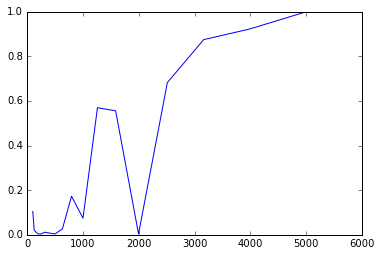

The single number R_w is : 18


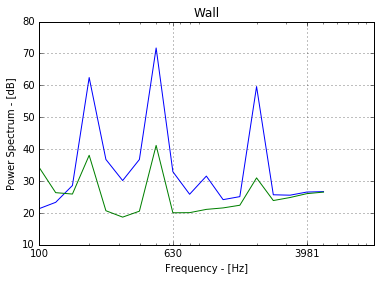

In [21]:
folder = '../../data/DiagnosisTest/wall/'
fs = 11000
freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'Wall'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]
Spreads = None

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, False, Spreads, octave_tick)

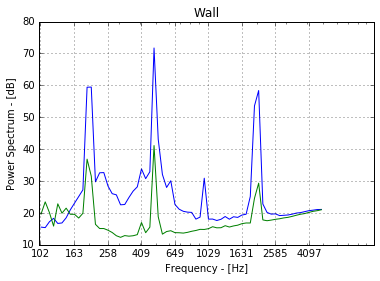

In [69]:
folder = '../../data/DiagnosisTest/wall/'
fs = 11000
freq, L1, L2, N, L1_list, L2_list, N_list = process_data(folder, fs)

scale = 'log'
title = 'Wall'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

L1_a = np.asarray(L1_list)
L1_min = L1_a.min(axis=0)
L1_max = L1_a.max(axis=0)

L2_a = np.asarray(L2_list)
L2_min = L2_a.min(axis=0)
L2_max = L2_a.max(axis=0)

Spreads = [L1_a.T, L2_a.T]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, False, Spreads, octave_tick)

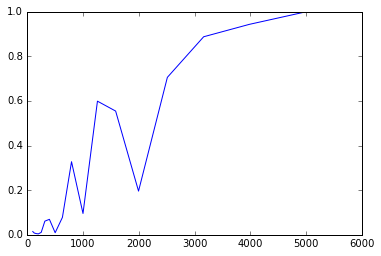

The single number R_w is : 18


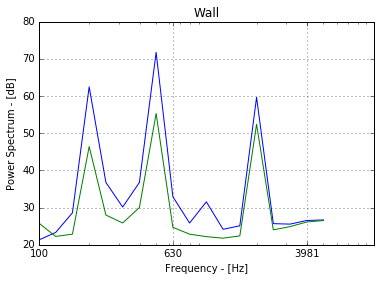

In [22]:
folder = '../../data/DiagnosisTest/leak/'
fs = 11000
freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'Wall'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]
Spreads = None

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, False, Spreads, octave_tick)

In [33]:
folder = '../../data/DasylabTests/AirLeakage01/'
fs = 44100

freq, L1, L2, R, ref_curve = process_data(folder, fs)

scale = 'log'
title = 'Wall'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]
Spreads = None

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, False, Spreads, octave_tick)

ValueError: Given center frequencies are not equally spaced.

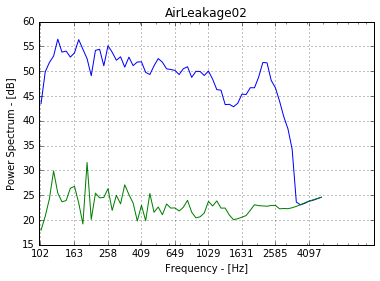

In [61]:
meas_folder = '../../data/DasylabTests/AirLeakage02/'
fs = 44100

freq, L1, L2, N = process_data(meas_folder)

scale = 'log'
title = 'AirLeakage02'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, octave_tick)

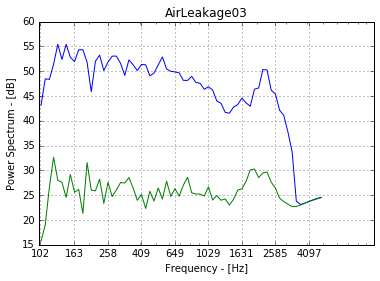

In [62]:
meas_folder = '../../data/DasylabTests/AirLeakage03/'
fs = 44100

freq, L1, L2, N = process_data(meas_folder, fs)

scale = 'log'
title = 'AirLeakage03'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, octave_tick)

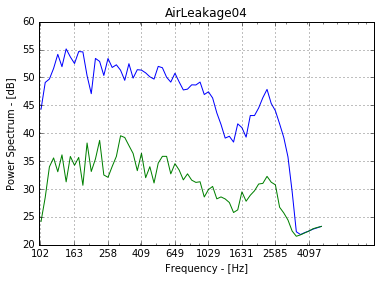

In [63]:
meas_folder = '../../data/DasylabTests/AirLeakage04/'
fs = 44100

freq, L1, L2, N = process_data(meas_folder, fs)

scale = 'log'
title = 'AirLeakage04'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, octave_tick)

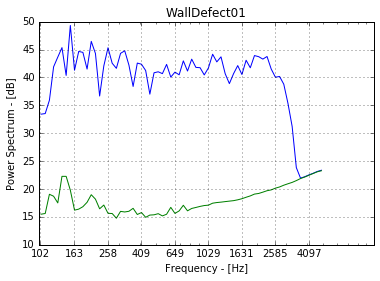

In [64]:
meas_folder = '../../data/DasylabTests/WallDefect01//'
fs = 44100

freq, L1, L2, N = process_data(meas_folder, fs)

scale = 'log'
title = 'WallDefect01'
x_label = 'Frequency - [Hz]'
y_label = 'Power Spectrum - [dB]'
octave_tick = np.asarray(freq, dtype=np.int)[::8]

plot_data([L1, L2], freq, title, y_label, x_label, scale, True, octave_tick)

In [ ]:
plt.figure()
rx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-1-rx.npy')
rx_spectra = abs(np.fft.rfft(rx_data))
plt.plot(rx_spectra)
rx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-2-rx.npy')
rx_spectra = abs(np.fft.rfft(rx_data))
plt.plot(rx_spectra)
rx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-3-rx.npy')
rx_spectra = abs(np.fft.rfft(rx_data))
plt.plot(rx_spectra)

plt.figure()
tx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-4-tx.npy')
tx_spectra = abs(np.fft.rfft(tx_data))
plt.plot(tx_spectra)
tx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-5-tx.npy')
tx_spectra = abs(np.fft.rfft(tx_data))
plt.plot(tx_spectra)
tx_data = np.load('../../data/DasylabTests/AirLeakage01/Measurement-6-tx.npy')
tx_spectra = abs(np.fft.rfft(tx_data))
plt.plot(tx_spectra)

plt.show()

In [17]:
s = Spectrum()

tx_t = np.load('../../data/DasylabTests/WallDefect01//Measurement-1-tx.npy')
f, tx_f, tx_f_db = s.fractional_octaves(tx_t, fs, start=100., stop=10000., fraction=12)

rx_t = np.load('../../data/DasylabTests/WallDefect01//Measurement-4-rx.npy')
f, rx_f, rx_f_db = s.fractional_octaves(rx_t, fs, start=100., stop=10000., fraction=12)

tl = tx_f_db - rx_f_db

In [18]:
plt.figure()
plt.title("Tx")
plt.plot(f.center, tx_f_db)
plt.grid()

plt.figure()
plt.title("Rx")
plt.plot(f.center, rx_f_db)
plt.grid()

plt.figure()
plt.title("Tranmission Loss")
plt.plot(f.center, tl)
plt.grid()

plt.show()

In [43]:
speaker_response = np.load('../../data/DasylabTests/SpeakerResponse/Measurement-1-tx.npy')
speaker_response_f = abs(np.fft.rfft(speaker_response))
freq = np.fft.fftfreq(speaker_response.size, 1/fs)[:(speaker_response_f.size-1)]
plt.figure()
plt.plot(freq, speaker_response_f[:-1])
plt.show()

In [42]:
freq[0]

0.0

In [24]:
s = Spectrum()
file_name = '../../data/DiagnosisTest/leak/source/'
fs = 11000

d = np.loadtxt(file_name, delimiter=';', dtype=np.str)
data = np.asarray(d[:, 0], dtype=np.float16)

freq, power_spectrum, power_spectrum_db = s.fractional_octaves(data, fs, start=100., stop=5000., fraction=3)

In [25]:
plt.figure()
plt.plot(data)

plt.figure()
plt.plot(freq.center, power_spectrum/power_spectrum.max())

plt.figure()
plt.plot(freq.center, power_spectrum_db)

plt.show()

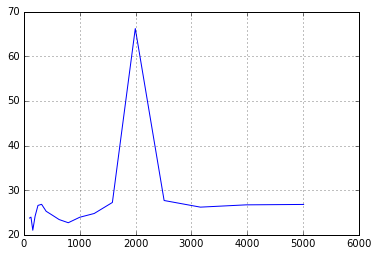

In [37]:
file_name = '../../data/DiagnosisTest/leak/source/15_1.CSV'
data_s = np.loadtxt(file_name, delimiter=';', dtype=np.str)
data = np.asarray(data_s[:, 0], dtype=np.float16)
freq, power_spectrum, power_spectrum_db = s.fractional_octaves(data, fs, start=100., stop=5000., fraction=3)
plt.plot(freq.center, power_spectrum_db)
plt.grid()
plt.show()

In [11]:
10**10

10000000000